In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [30]:
train = pd.read_csv("model.csv")
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,29.85,29.85,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,53.85,108.15,1,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


# 1. Determine X and Y variables

In [31]:
X = train.drop(["customerID", "Churn"], axis = 1)
y = train["Churn"]

# 2. Splitting Training and Testing data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

# 3. Modeling

### Logistic Regression

0.gender: 0.052410742064081806
1.SeniorCitizen: 0.2580734162294229
2.Partner: 0.060184497255260705
3.Dependents: -0.1819797429376227
4.tenure: -0.05928456172841653
5.PhoneService: -0.5729588143695165
6.MultipleLines: 0.2159386883781098
7.OnlineSecurity: -0.5678166805118811
8.OnlineBackup: -0.245521272316091
9.DeviceProtection: -0.14024096091236238
10.TechSupport: -0.5187584678075223
11.StreamingTV: 0.013727071180462964
12.StreamingMovies: 0.11224852773139977
13.PaperlessBilling: 0.4318402296565737
14.MonthlyCharges: 0.00918985379054641
15.TotalCharges: 0.0002833417445449348
16.InternetService_Fiber optic: 0.4933225413529594
17.InternetService_No: -0.504359518467607
18.Contract_One year: -0.3590008011294232
19.Contract_Two year: -0.6268468643397349
20.PaymentMethod_Credit card (automatic): -0.19131460132773792
21.PaymentMethod_Electronic check: 0.28181026208420257
22.PaymentMethod_Mailed check: -0.21381086252392498


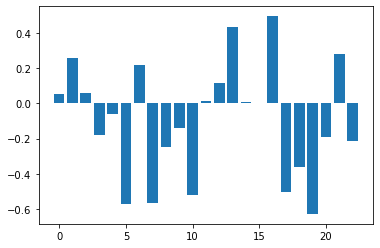

In [33]:
log = LogisticRegression()
log.fit(X_train, y_train)
importance = log.coef_[0]
for i, v in enumerate(importance):
    print(f"{i}.{X_train.columns[i]}: {v}")
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [38]:
def evaluate(model, X_test, y_test):
    prediction_test = model.predict(X_test)
    results = pd.DataFrame({"Accuracy":[metrics.accuracy_score(y_test, prediction_test)],
                           "Precision":[metrics.precision_score(y_test, prediction_test)],
                           "Recall":[metrics.recall_score(y_test, prediction_test)]})
    return results

In [52]:
def calculate_roc_auc(model,X_test, y_test):
    prediction_test = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_test)
    score = pd.DataFrame({"ROC-AUC":[metrics.auc(fpr, tpr)]})
    plot_roc_auc(fpr, tpr)
    return score

In [53]:
def plot_roc_auc(fpr, tpr):
    f, ax = plt.subplots(figsize=(14,8))
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label="AUC = %0.2f" %(roc_auc))
    plt.plot([0,1],[0,1], linestyle = "--", lw=3, color="r", label= "Random", alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

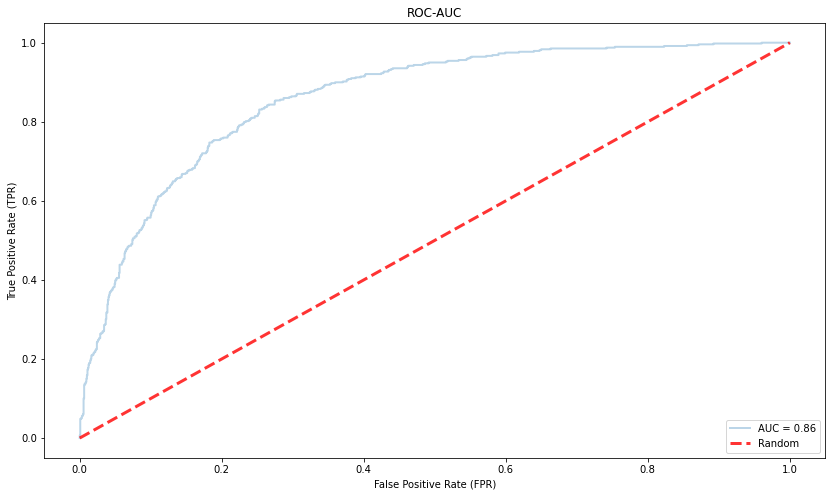

,ROC-AUC
0,0.860128


In [54]:
calculate_roc_auc(log, X_test, y_test)

In [55]:
evaluate(log, X_test, y_test)

,Accuracy,Precision,Recall
0,0.810903,0.691099,0.551148


### XGB 

C:\Users\ACI\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


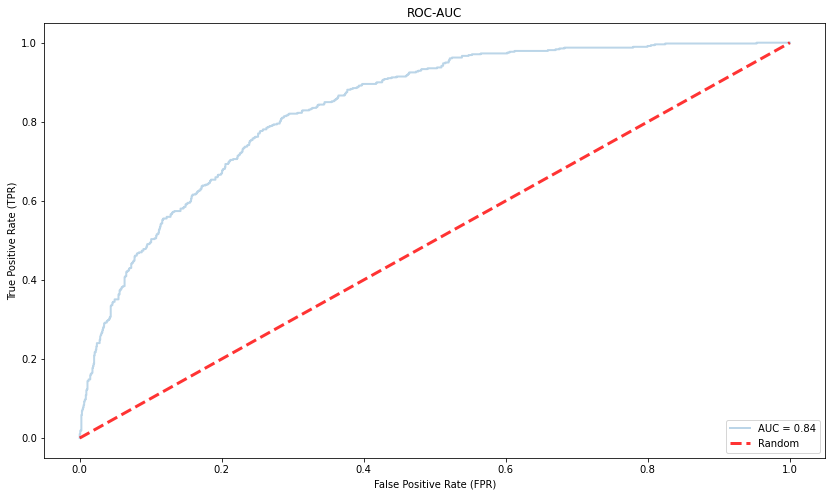

,ROC-AUC
0,0.837202


In [57]:
xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=500, n_jobs=-1)
xgb.fit(X_train, y_train)
calculate_roc_auc(xgb, X_test, y_test)

In [58]:
evaluate(xgb, X_test, y_test)

,Accuracy,Precision,Recall
0,0.788756,0.642667,0.503132


In [70]:
clf=RandomForestClassifier(n_jobs=4,n_estimators=500,max_depth=6)
clf.fit(X,y)

RandomForestClassifier(max_depth=6, n_estimators=500, n_jobs=4)

In [71]:
fscores = pd.DataFrame({'feature':X.columns,'importance':clf.feature_importances_}).sort_values(by='importance',ascending=True)
fscores.tail()

,feature,importance
21,PaymentMethod_Electronic check,0.089237
19,Contract_Two year,0.096774
16,InternetService_Fiber optic,0.129945
15,TotalCharges,0.133406
4,tenure,0.208515


<BarContainer object of 23 artists>

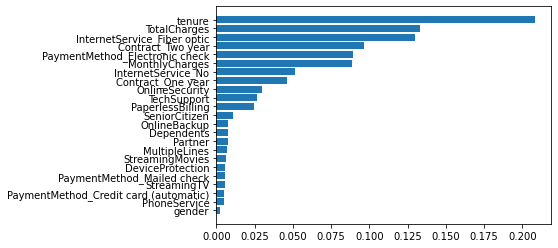

In [73]:
fig=plt.Figure(figsize=(14,8))
plt.barh(fscores.feature,fscores.importance)
# fig.update_yaxes(ticktext=fscores.feature,tickvals=list(range(27)))
# #fig.add_traces(go.Bar(x=fm))
# fig.update_layout(xaxis_title='Feature Importance', title='Feature Importance via RandomForest')
# fig.update_layout(yaxis={'categoryorder':'total ascending'})

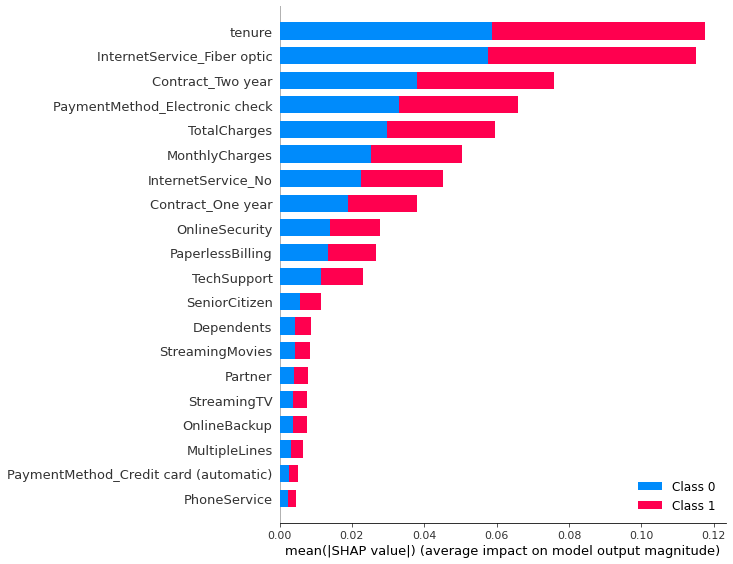

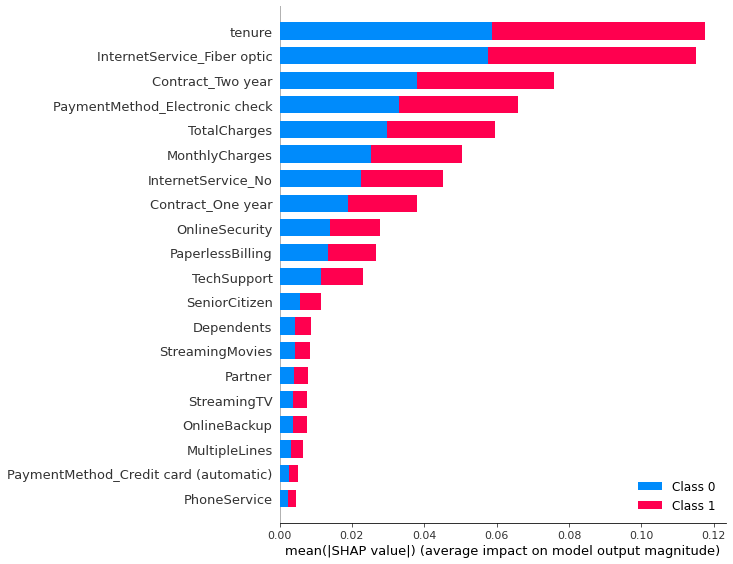

In [76]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)